## Pre-work

### Set-up

In [1]:
!pip install tensorflow==1.2.0
!pip install keras==2.0.9

     |████████████████████████████████| 35.0MB 48.6MB/s 
     |████████████████████████████████| 245kB 62.9MB/s 
     |████████████████████████████████| 890kB 56.2MB/s 
  Created wheel for markdown: filename=Markdown-2.2.0-cp36-none-any.whl size=136274 sha256=a7b0d6379cbfc8f86a4bffc423f3512c05de8fe7dd8e4355d93a70ff7f9c5e13
  Stored in directory: /root/.cache/pip/wheels/b6/52/17/f0af18e3e0ec6fa60b361ffed15b4c3468f6f3bcdb87fbe079
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107221 sha256=b1fac2306da95e57234b775c205b159790aa908b38a6f7b84cc99003ca9c1f43
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built markdown html5lib
ERROR: tensorboard 1.14.0 has requirement markdown>=2.6.8, but you'll have markdown 2.2.0 which is incompatible.
ERROR: stable-baselines 2.2.1 has requirement tensorflow>=1.5.0, but you'll have tensorflow 1.2.0 which is incompatible.
ERROR: magenta 0.3.19 has requ

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

seed = 7
np.random.seed(seed)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
import tensorflow as tf
import pandas as pd
from pandas import Series,DataFrame

import io
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.ticker as ticker

import collections

from keras import backend as k
# from tensorflow.python.framework import ops
# ops.reset_default_graph()

In [0]:
from google.colab import files
import io

### Process Data

In [5]:
uploaded = files.upload()

Saving DryCreek_input_add_label.csv to DryCreek_input_add_label.csv


In [6]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "DryCreek_input_add_label.csv" with length 769710 bytes


In [7]:
DryCreek = pd.read_csv(io.StringIO(uploaded['DryCreek_input_add_label.csv'].decode('utf-8')))
DryCreekDate = DryCreek.iloc[:,0]
DryCreekDate.head()

0    731000.0
1    731000.0
2    731000.0
3    731000.0
4    731000.0
Name: Date, dtype: float64

In [14]:
DryCreek = pd.read_csv(io.StringIO(uploaded['DryCreek_input_add_label.csv'].decode('utf-8')))
DryCreek = DryCreek.iloc[:, 1:] # remove date col cuz it's meaningless
# DryCreek['Date'] = pd.to_datetime(DryCreek['Date'],unit='s') if here is timestamp
DryCreek.head()

,1-day aggregated anomaly LG Mean daily Q m^3/s,LWR_P (precipitation),LWR_T (temperature),LWR_SWE (snow water equivalent),LWR_Melt (snow melt),LWR_ET (evapotranspiration),TL_P,TL_T,TL_SWE,TL_Melt,TL_ET,LWR_Soil1 (soil moisture at 10 cm deep),LWR_Soil5,LWR_Soil6,LWR_Soil10,TL_Soil1,TL_Soil5,TL_Soil6,TL_Soil10
0,0.007631,0.02,-5.4043,18.330,5.4717,0.19329,0.14,-2.79130,175.46,13.485,0.55372,0.17961,0.078,0.093609,0.072,0.15370,0.205,0.16452,0.16678
1,0.007957,0.00,-5.1292,17.073,4.9335,0.28683,0.00,-6.34170,171.53,19.824,0.52772,0.17846,0.078,0.090583,0.072,0.15300,0.205,0.16350,0.16888
2,0.014199,0.00,-4.0625,15.907,12.2590,0.43448,0.00,0.74167,170.84,7.176,0.65155,0.17046,0.078,0.082708,0.072,0.15246,0.205,0.16242,0.17075
3,0.006009,0.00,-2.2333,15.781,9.5082,0.44985,0.00,4.33750,168.02,17.880,0.61387,0.16458,0.078,0.082500,0.072,0.15200,0.205,0.16237,0.17263
4,0.004121,0.00,-1.3625,16.195,5.3222,0.49253,0.00,5.51670,161.25,19.196,0.57884,0.16229,0.078,0.082125,0.072,0.15238,0.205,0.16446,0.17375


In [15]:
DryCreek.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6044 entries, 0 to 6043
Data columns (total 19 columns):
1-day aggregated anomaly LG Mean daily Q m^3/s    6044 non-null float64
LWR_P (precipitation)                             6044 non-null float64
LWR_T (temperature)                               6044 non-null float64
LWR_SWE (snow water equivalent)                   6044 non-null float64
LWR_Melt (snow melt)                              6044 non-null float64
LWR_ET (evapotranspiration)                       6044 non-null float64
TL_P                                              6044 non-null float64
TL_T                                              6044 non-null float64
TL_SWE                                            6044 non-null float64
TL_Melt                                           6044 non-null float64
TL_ET                                             6044 non-null float64
LWR_Soil1 (soil moisture at 10 cm deep)           6044 non-null float64
LWR_Soil5                    

### Visualize data

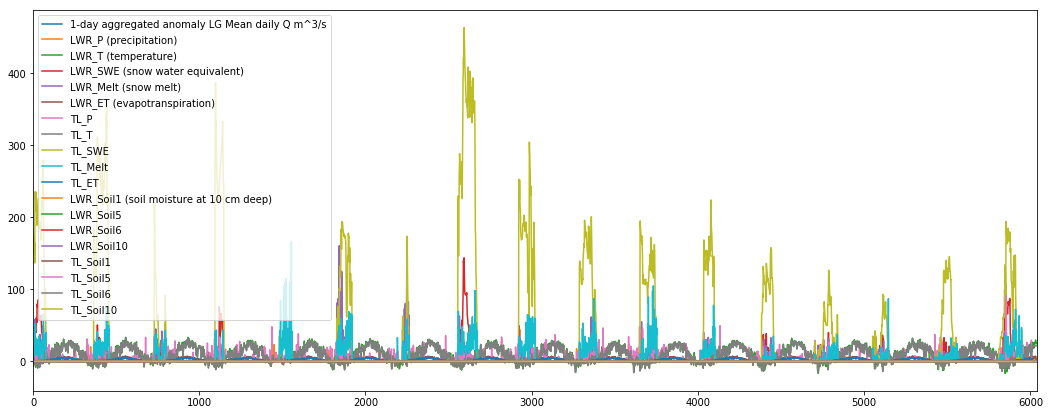

In [0]:
DryCreek.plot(figsize=(18,7))

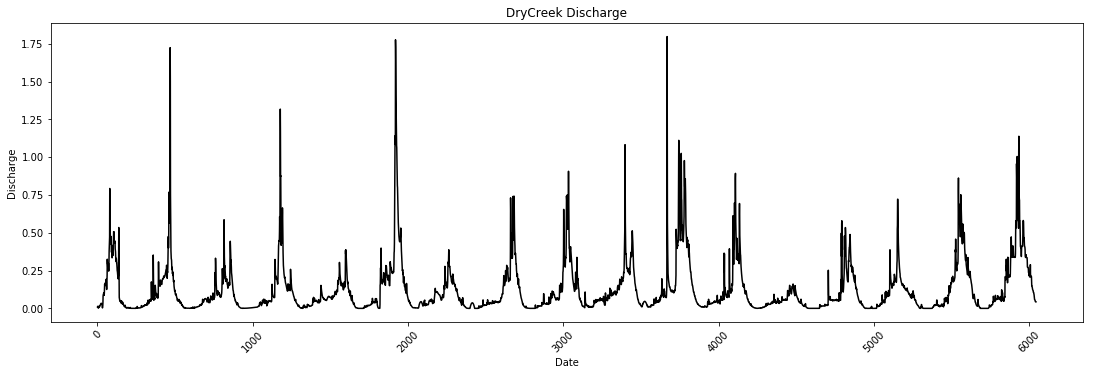

In [17]:
# create the plot space upon which to plot the data
fig, ax= plt.subplots()

# add the x-axis and the y-axis to the plot
ax.plot(DryCreek['1-day aggregated anomaly LG Mean daily Q m^3/s'], 
        color = 'black')

# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Discharge",
       title="DryCreek Discharge");

# set plot size
fig.set_size_inches(18.5, 5.5)

## Nested Cross Validation

**Day Forward-Chaining Nested Cross-Validation**

![alt text](https://miro.medium.com/max/2056/1*2-zaRQ-dsv8KWxOlzc8VaA.png)
*source: https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9*

Here, I implement 4-1, 8-1, 12-1, 15.5-1 (in yrs) as training set vs.testing set

## Multivariate LSTM Time Series Model

The model without considering lagging and previous label data that we already tried before has huge error, thus here I only cover the LSTM model considering lagging and previous label data.

For convenience, here we assume we only have one hidden layer, the optimizer == "adam", and the timestep == 1.

All the models are runned 15 epochs just for testing convenience.

### M1 4-1 

*4x365=1460, 0.8x1460=1168, 0.2x1460=292, 5x365=1825*

In [18]:
values = DryCreek.values

# ensure all data is float
values = values.astype('float64')
values

array([[ 7.6310e-03,  2.0000e-02, -5.4043e+00, ...,  2.0500e-01,
         1.6452e-01,  1.6678e-01],
       [ 7.9571e-03,  0.0000e+00, -5.1292e+00, ...,  2.0500e-01,
         1.6350e-01,  1.6888e-01],
       [ 1.4199e-02,  0.0000e+00, -4.0625e+00, ...,  2.0500e-01,
         1.6242e-01,  1.7075e-01],
       ...,
       [ 4.2781e-02,  0.0000e+00,  2.5200e+01, ...,  7.4542e-02,
         4.5083e-02,  7.3083e-02],
       [ 4.3380e-02,  0.0000e+00,  2.5200e+01, ...,  7.3958e-02,
         4.3875e-02,  7.1542e-02],
       [ 4.3174e-02,  0.0000e+00,  2.5200e+01, ...,  7.3786e-02,
         4.3000e-02,  7.0643e-02]])

In [0]:
#convert data to supervised form

def to_supervised(data,dropNa = True,lag = timeSteps):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    
    # drop rows with missing values
    df.dropna(inplace = True)
    
    # specify columns for input and output pairs
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    
    return supervised_data

In [30]:
timeSteps = 1

supervised = to_supervised(values,lag=timeSteps) # use `scaled` instead of `values` if choose to scale the data
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.007631,0.02,-5.4043,18.330,5.4717,0.19329,0.14,-2.79130,175.46,13.485,0.55372,0.17961,0.078,0.093609,0.072,0.15370,0.205,0.16452,0.16678,0.007957
1,0.007957,0.00,-5.1292,17.073,4.9335,0.28683,0.00,-6.34170,171.53,19.824,0.52772,0.17846,0.078,0.090583,0.072,0.15300,0.205,0.16350,0.16888,0.014199
2,0.014199,0.00,-4.0625,15.907,12.2590,0.43448,0.00,0.74167,170.84,7.176,0.65155,0.17046,0.078,0.082708,0.072,0.15246,0.205,0.16242,0.17075,0.006009
3,0.006009,0.00,-2.2333,15.781,9.5082,0.44985,0.00,4.33750,168.02,17.880,0.61387,0.16458,0.078,0.082500,0.072,0.15200,0.205,0.16237,0.17263,0.004121
4,0.004121,0.00,-1.3625,16.195,5.3222,0.49253,0.00,5.51670,161.25,19.196,0.57884,0.16229,0.078,0.082125,0.072,0.15238,0.205,0.16446,0.17375,0.006440


In [38]:
# set the training and testing set
split_time = 1460
end_time = 1825

features = DryCreek.shape[1] # num of input features
X = supervised[:,:features*timeSteps] # column 1-18
y = supervised[:,features*timeSteps] # column 19

x_train = X[:split_time,:]
x_test = X[split_time:end_time,:]
y_train = y[:split_time]
y_test = y[split_time:end_time]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1460, 19) (365, 19) (1460,) (365,)


In [42]:
#convert data to fit for lstm
features = values.shape[1]

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(1460, 1, 19) (365, 1, 19)


In [43]:
# split the training set into training subset and validation subset
validation_perc = 0.2
val_split = round(len(x_train)*validation_perc)
val_split

292

In [44]:
x_train_subset = x_train[:-val_split,:,:]
y_train_subset = y_train[:-val_split]
x_validation_subset = x_train[-val_split:,:,:]
y_validation_subset = y_train[-val_split:]
print (x_train_subset.shape, y_train_subset.shape, x_validation_subset.shape, y_validation_subset.shape)

(1168, 1, 19) (1168,) (292, 1, 19) (292,)


In [0]:
#define the model
model = Sequential()
model.add(LSTM(50,input_shape = (x_train.shape[1],x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss = "mean_squared_error", optimizer = "adam")

history =  model.fit(x_train_subset,y_train_subset, validation_data = (x_validation_subset,y_validation_subset), epochs = 15 , batch_size = 32, verbose = 0, shuffle = False)

*validation prediction (if there's any other model to choose from)*

In [0]:
val_time = list(range(split_time - val_split, split_time))
val_pred = model.predict(x_validation_subset)
val_test = y_validation_subset.reshape(len(y_validation_subset), 1)

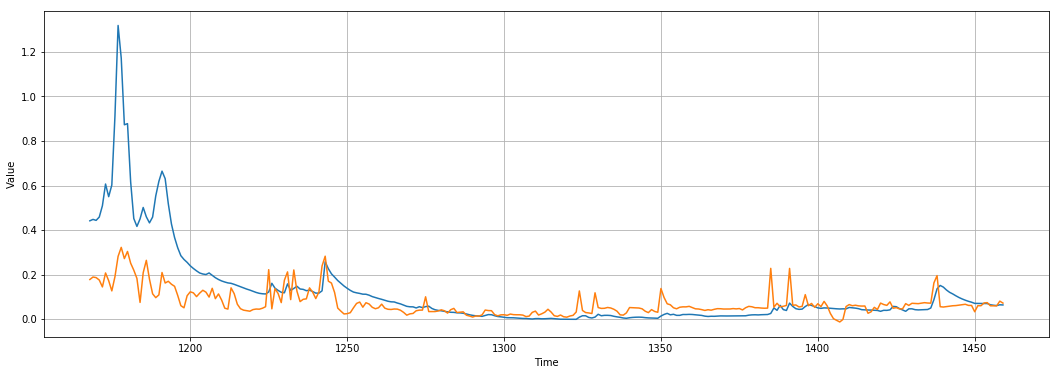

In [51]:
plt.figure(figsize=(18, 6))
plot_series(val_time, val_test)
plot_series(val_time, val_pred)

In [0]:
mean_absolute_error(val_test, val_pred)

In [0]:
mean_squared_error(val_pred,val_test)

*test prediction*

In [0]:
test_time = list(range(split_time, split_time + x_test.shape[0]))
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

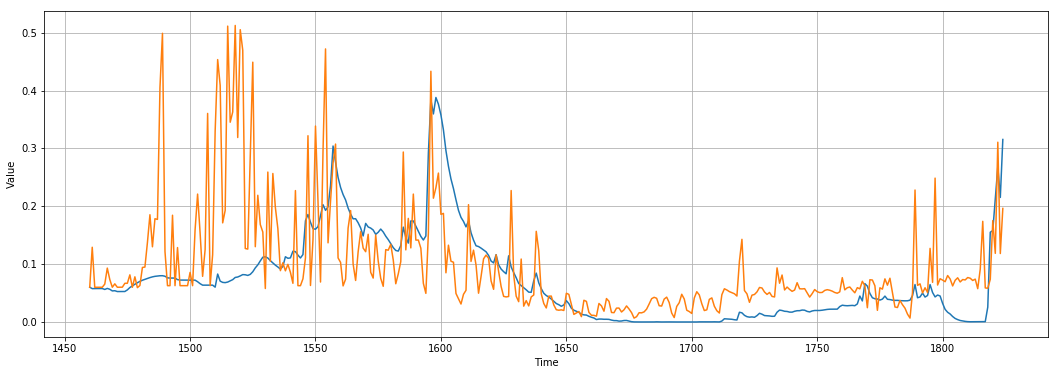

In [53]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

In [0]:
mean_absolute_error(val_test, val_pred)

In [0]:
mean_squared_error(val_pred,val_test)

### M1 8-1 

*8x365=2920, 0.8x2920=2336, 0.2x1460=584, 9x365=3285*

In [54]:
timeSteps = 1

supervised = to_supervised(values,lag=timeSteps) # use `scaled` instead of `values` if choose to scale the data
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.007631,0.02,-5.4043,18.330,5.4717,0.19329,0.14,-2.79130,175.46,13.485,0.55372,0.17961,0.078,0.093609,0.072,0.15370,0.205,0.16452,0.16678,0.007957
1,0.007957,0.00,-5.1292,17.073,4.9335,0.28683,0.00,-6.34170,171.53,19.824,0.52772,0.17846,0.078,0.090583,0.072,0.15300,0.205,0.16350,0.16888,0.014199
2,0.014199,0.00,-4.0625,15.907,12.2590,0.43448,0.00,0.74167,170.84,7.176,0.65155,0.17046,0.078,0.082708,0.072,0.15246,0.205,0.16242,0.17075,0.006009
3,0.006009,0.00,-2.2333,15.781,9.5082,0.44985,0.00,4.33750,168.02,17.880,0.61387,0.16458,0.078,0.082500,0.072,0.15200,0.205,0.16237,0.17263,0.004121
4,0.004121,0.00,-1.3625,16.195,5.3222,0.49253,0.00,5.51670,161.25,19.196,0.57884,0.16229,0.078,0.082125,0.072,0.15238,0.205,0.16446,0.17375,0.006440


In [55]:
# set the training and testing set
split_time = 2920
end_time = 3285

features = DryCreek.shape[1] # num of input features
X = supervised[:,:features*timeSteps] # column 1-18
y = supervised[:,features*timeSteps] # column 19

x_train = X[:split_time,:]
x_test = X[split_time:end_time,:]
y_train = y[:split_time]
y_test = y[split_time:end_time]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(2920, 19) (365, 19) (2920,) (365,)


In [56]:
#convert data to fit for lstm
features = values.shape[1]

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(2920, 1, 19) (365, 1, 19)


In [57]:
# split the training set into training subset and validation subset
validation_perc = 0.2
val_split = round(len(x_train)*validation_perc)
val_split

584

In [58]:
x_train_subset = x_train[:-val_split,:,:]
y_train_subset = y_train[:-val_split]
x_validation_subset = x_train[-val_split:,:,:]
y_validation_subset = y_train[-val_split:]
print (x_train_subset.shape, y_train_subset.shape, x_validation_subset.shape, y_validation_subset.shape)

(2336, 1, 19) (2336,) (584, 1, 19) (584,)


In [0]:
#define the model
model = Sequential()
model.add(LSTM(50,input_shape = (x_train.shape[1],x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss = "mean_squared_error", optimizer = "adam")

history =  model.fit(x_train_subset,y_train_subset, validation_data = (x_validation_subset,y_validation_subset), epochs = 15 , batch_size = 32, verbose = 0, shuffle = False)

*validation prediction (if there's any other model to choose from)*

In [0]:
val_time = list(range(split_time - val_split, split_time))
val_pred = model.predict(x_validation_subset)
val_test = y_validation_subset.reshape(len(y_validation_subset), 1)

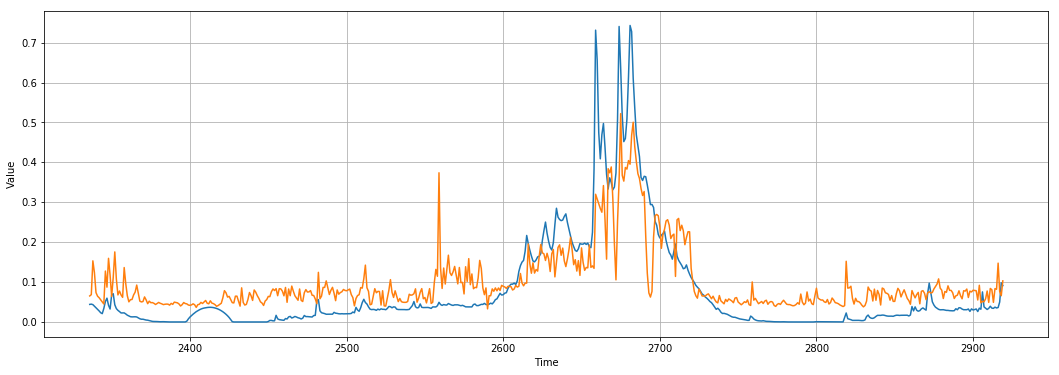

In [62]:
plt.figure(figsize=(18, 6))
plot_series(val_time, val_test)
plot_series(val_time, val_pred)

In [0]:
mean_absolute_error(val_test, val_pred)

In [0]:
mean_squared_error(val_pred,val_test)

*test prediction*

In [0]:
test_time = list(range(split_time, split_time + x_test.shape[0]))
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

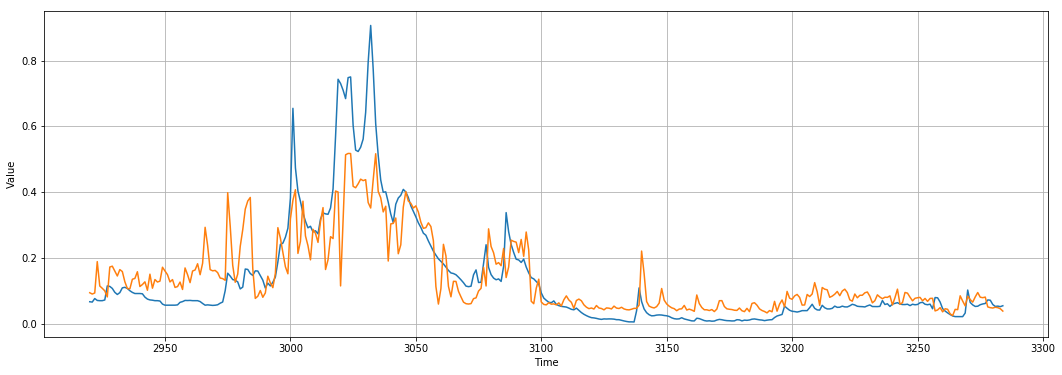

In [64]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

In [0]:
mean_absolute_error(val_test, val_pred)

In [0]:
mean_squared_error(val_pred,val_test)

### M1 12-1 

*12x365=4380, 0.8x4380=3504, 0.2x4380=876, 13x365=4745*

In [65]:
timeSteps = 1

supervised = to_supervised(values,lag=timeSteps) # use `scaled` instead of `values` if choose to scale the data
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.007631,0.02,-5.4043,18.330,5.4717,0.19329,0.14,-2.79130,175.46,13.485,0.55372,0.17961,0.078,0.093609,0.072,0.15370,0.205,0.16452,0.16678,0.007957
1,0.007957,0.00,-5.1292,17.073,4.9335,0.28683,0.00,-6.34170,171.53,19.824,0.52772,0.17846,0.078,0.090583,0.072,0.15300,0.205,0.16350,0.16888,0.014199
2,0.014199,0.00,-4.0625,15.907,12.2590,0.43448,0.00,0.74167,170.84,7.176,0.65155,0.17046,0.078,0.082708,0.072,0.15246,0.205,0.16242,0.17075,0.006009
3,0.006009,0.00,-2.2333,15.781,9.5082,0.44985,0.00,4.33750,168.02,17.880,0.61387,0.16458,0.078,0.082500,0.072,0.15200,0.205,0.16237,0.17263,0.004121
4,0.004121,0.00,-1.3625,16.195,5.3222,0.49253,0.00,5.51670,161.25,19.196,0.57884,0.16229,0.078,0.082125,0.072,0.15238,0.205,0.16446,0.17375,0.006440


In [67]:
# set the training and testing set
split_time = 4380
end_time = 4745

features = DryCreek.shape[1] # num of input features
X = supervised[:,:features*timeSteps] # column 1-18
y = supervised[:,features*timeSteps] # column 19

x_train = X[:split_time,:]
x_test = X[split_time:end_time,:]
y_train = y[:split_time]
y_test = y[split_time:end_time]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(4380, 19) (365, 19) (4380,) (365,)


In [68]:
#convert data to fit for lstm
features = values.shape[1]

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(4380, 1, 19) (365, 1, 19)


In [69]:
# split the training set into training subset and validation subset
validation_perc = 0.2
val_split = round(len(x_train)*validation_perc)
val_split

876

In [70]:
x_train_subset = x_train[:-val_split,:,:]
y_train_subset = y_train[:-val_split]
x_validation_subset = x_train[-val_split:,:,:]
y_validation_subset = y_train[-val_split:]
print (x_train_subset.shape, y_train_subset.shape, x_validation_subset.shape, y_validation_subset.shape)

(3504, 1, 19) (3504,) (876, 1, 19) (876,)


In [0]:
#define the model
model = Sequential()
model.add(LSTM(50,input_shape = (x_train.shape[1],x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss = "mean_squared_error", optimizer = "adam")

history =  model.fit(x_train_subset,y_train_subset, validation_data = (x_validation_subset,y_validation_subset), epochs = 15 , batch_size = 32, verbose = 0, shuffle = False)

*validation prediction (if there's any other model to choose from)*

In [0]:
val_time = list(range(split_time - val_split, split_time))
val_pred = model.predict(x_validation_subset)
val_test = y_validation_subset.reshape(len(y_validation_subset), 1)

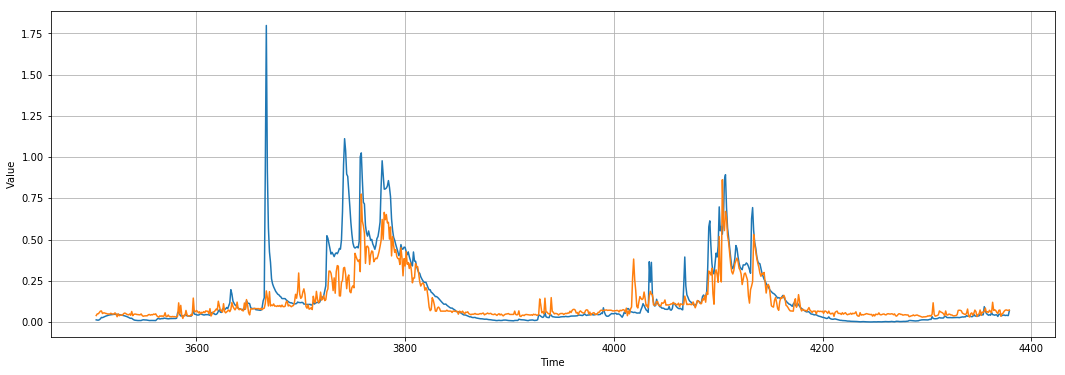

In [73]:
plt.figure(figsize=(18, 6))
plot_series(val_time, val_test)
plot_series(val_time, val_pred)

In [0]:
mean_absolute_error(val_test, val_pred)

In [0]:
mean_squared_error(val_pred,val_test)

*test prediction*

In [0]:
test_time = list(range(split_time, split_time + x_test.shape[0]))
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

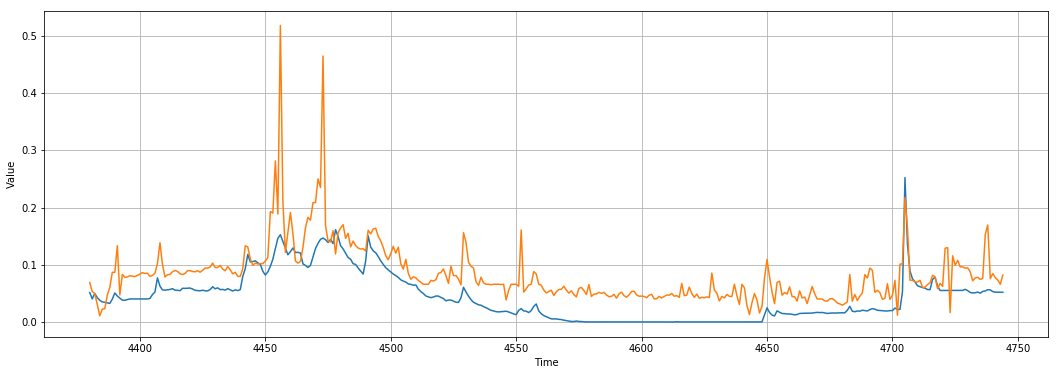

In [75]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

In [0]:
mean_absolute_error(val_test, val_pred)

In [0]:
mean_squared_error(val_pred,val_test)

### M1 15.5-1 

*15.5x365\~=5658, 0.8x5658\~=4526, 0.2x5658\~=1132, 16.5x365\~=6023*

In [76]:
timeSteps = 1

supervised = to_supervised(values,lag=timeSteps) # use `scaled` instead of `values` if choose to scale the data
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.007631,0.02,-5.4043,18.330,5.4717,0.19329,0.14,-2.79130,175.46,13.485,0.55372,0.17961,0.078,0.093609,0.072,0.15370,0.205,0.16452,0.16678,0.007957
1,0.007957,0.00,-5.1292,17.073,4.9335,0.28683,0.00,-6.34170,171.53,19.824,0.52772,0.17846,0.078,0.090583,0.072,0.15300,0.205,0.16350,0.16888,0.014199
2,0.014199,0.00,-4.0625,15.907,12.2590,0.43448,0.00,0.74167,170.84,7.176,0.65155,0.17046,0.078,0.082708,0.072,0.15246,0.205,0.16242,0.17075,0.006009
3,0.006009,0.00,-2.2333,15.781,9.5082,0.44985,0.00,4.33750,168.02,17.880,0.61387,0.16458,0.078,0.082500,0.072,0.15200,0.205,0.16237,0.17263,0.004121
4,0.004121,0.00,-1.3625,16.195,5.3222,0.49253,0.00,5.51670,161.25,19.196,0.57884,0.16229,0.078,0.082125,0.072,0.15238,0.205,0.16446,0.17375,0.006440


In [77]:
# set the training and testing set
split_time = 5658
end_time = 6023

features = DryCreek.shape[1] # num of input features
X = supervised[:,:features*timeSteps] # column 1-18
y = supervised[:,features*timeSteps] # column 19

x_train = X[:split_time,:]
x_test = X[split_time:end_time,:]
y_train = y[:split_time]
y_test = y[split_time:end_time]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(5658, 19) (365, 19) (5658,) (365,)


In [78]:
#convert data to fit for lstm
features = values.shape[1]

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(5658, 1, 19) (365, 1, 19)


In [79]:
# split the training set into training subset and validation subset
validation_perc = 0.2
val_split = round(len(x_train)*validation_perc)
val_split

1132

In [80]:
x_train_subset = x_train[:-val_split,:,:]
y_train_subset = y_train[:-val_split]
x_validation_subset = x_train[-val_split:,:,:]
y_validation_subset = y_train[-val_split:]
print (x_train_subset.shape, y_train_subset.shape, x_validation_subset.shape, y_validation_subset.shape)

(4526, 1, 19) (4526,) (1132, 1, 19) (1132,)


In [0]:
#define the model
model = Sequential()
model.add(LSTM(50,input_shape = (x_train.shape[1],x_train.shape[2]))) # define the LSTM with 50 neurons in the first hidden layer 
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(loss = "mean_squared_error", optimizer = "adam")

history =  model.fit(x_train_subset,y_train_subset, validation_data = (x_validation_subset,y_validation_subset), epochs = 15 , batch_size = 32, verbose = 0, shuffle = False)

*validation prediction (if there's any other model to choose from)*

In [0]:
val_time = list(range(split_time - val_split, split_time))
val_pred = model.predict(x_validation_subset)
val_test = y_validation_subset.reshape(len(y_validation_subset), 1)

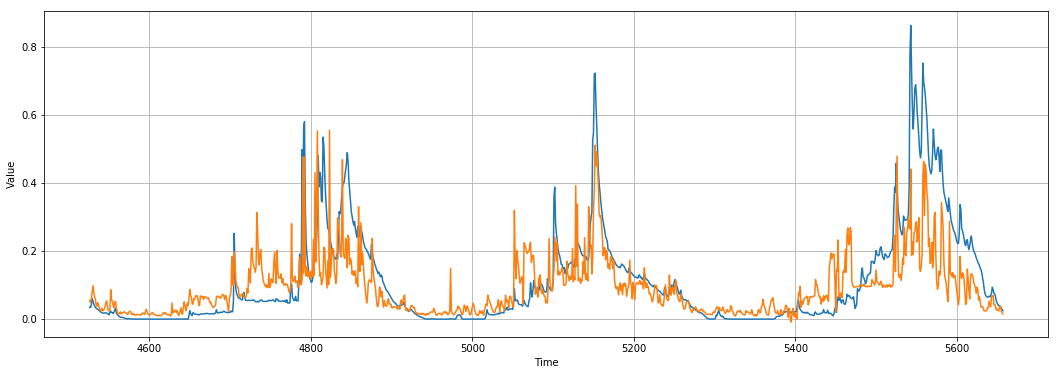

In [83]:
plt.figure(figsize=(18, 6))
plot_series(val_time, val_test)
plot_series(val_time, val_pred)

In [0]:
mean_absolute_error(val_test, val_pred)

In [0]:
mean_squared_error(val_pred,val_test)

*test prediction*

In [0]:
test_time = list(range(split_time, split_time + x_test.shape[0]))
y_pred = model.predict(x_test)
y_test = y_test.reshape(len(y_test), 1)

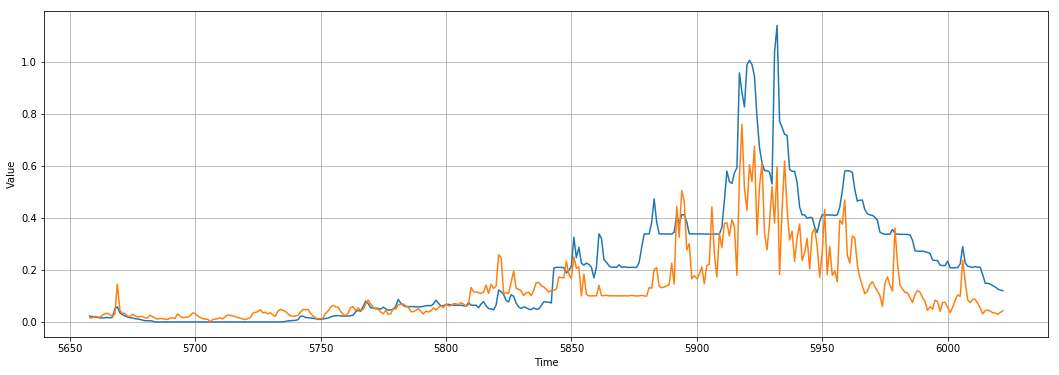

In [85]:
plt.figure(figsize=(18, 6))
plot_series(test_time, y_test)
plot_series(test_time, y_pred)

In [0]:
mean_absolute_error(val_test, val_pred)

In [0]:
mean_squared_error(val_pred,val_test)

## Conclusion